# Temporal Convolutional Network (TCN) for MABe 2025

This notebook implements a TCN for multi-agent behavior categorization using the preprocessed data.

In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Check for GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

/Users/zihanghuang/data-mining/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## Configuration

In [2]:
DATA_DIR = './data/processed/train'
BATCH_SIZE = 64 
SEQ_LEN = 100   # Window size for training
HIDDEN_CHANNELS = 64
KERNEL_SIZE = 3
DROPOUT = 0.2
EPOCHS = 10
LEARNING_RATE = 0.001

# Ensure data directory exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Processed data directory not found: {DATA_DIR}")

## Dataset Definition

In [3]:
class MouseBehaviorDataset(Dataset):
    def __init__(self, data_dir, video_ids, behavior_vocab=None, seq_len=100, is_training=True):
        self.data_dir = data_dir
        self.video_ids = video_ids
        self.seq_len = seq_len
        self.is_training = is_training
        
        # Load first video to get feature columns and behavior vocab if not provided
        self.feature_cols = self._get_feature_columns()
        if behavior_vocab is None:
            self.behavior_vocab = self._build_vocab()
        else:
            self.behavior_vocab = behavior_vocab
            
        self.num_classes = len(self.behavior_vocab)
        self.num_features = len(self.feature_cols)
        
        # Initialize scaler
        self.scaler = self._get_scaler()
        
        print(f"Dataset initialized with {len(video_ids)} videos")
        print(f"Num features: {self.num_features}")
        print(f"Num classes: {self.num_classes}")

    def _get_feature_columns(self):
        # Load a sample file to check columns
        sample_vid = self.video_ids[0]
        df = pd.read_parquet(os.path.join(self.data_dir, f"{sample_vid}.parquet"))
        
        # Exclude non-feature columns
        exclude = ['video_frame', 'mouse_id', 'video_id', 'lab_id']
        cols = [c for c in df.columns if c not in exclude]
        
        # Handle variable dist_to_mouse columns by ensuring we have a fixed set for up to 4 mice
        # We will dynamically add missing columns with 0s during loading
        base_cols = [c for c in cols if not c.startswith('dist_to_mouse')]
        for i in range(1, 5):
            base_cols.append(f'dist_to_mouse_{i}')
            
        return base_cols

    def _build_vocab(self):
        behaviors = set()
        # Scan a subset of annotations to build vocab (or all if feasible)
        # For speed, we'll scan first 100 or all if less
        scan_ids = self.video_ids[:100]
        for vid in scan_ids:
            anno_path = os.path.join(self.data_dir, f"{vid}_annotations.parquet")
            if os.path.exists(anno_path):
                df = pd.read_parquet(anno_path)
                behaviors.update(df['action'].unique())
        
        return sorted(list(behaviors))

    def _get_scaler(self):
        import pickle
        scaler_path = os.path.join(self.data_dir, 'scaler.pkl')
        
        if self.is_training:
            print("Fitting scaler on training data subset...")
            scaler = StandardScaler()
            # Fit on a random subset of 500 videos (or less if dataset is smaller)
            sample_size = min(len(self.video_ids), 500)
            sample_vids = np.random.choice(self.video_ids, sample_size, replace=False)
            
            all_feats = []
            for vid in tqdm(sample_vids, desc="Loading scaler data"):
                feat_path = os.path.join(self.data_dir, f"{vid}.parquet")
                if os.path.exists(feat_path):
                    df = pd.read_parquet(feat_path)
                    # Ensure columns
                    for col in self.feature_cols:
                        if col not in df.columns:
                            df[col] = 0.0
                    
                    # Extract features
                    feats = df[self.feature_cols].values.astype(np.float32)
                    feats = np.nan_to_num(feats)
                    
                    # Subsample rows to save memory (e.g. every 10th frame)
                    all_feats.append(feats[::10])
            
            if all_feats:
                concat_feats = np.concatenate(all_feats, axis=0)
                scaler.fit(concat_feats)
                print(f"Scaler fitted. Mean: {scaler.mean_[:5]}...")
                with open(scaler_path, 'wb') as f:
                    pickle.dump(scaler, f)
                return scaler
            else:
                print("Warning: No data found to fit scaler.")
                return None
        else:
            # Validation/Test: Load scaler
            if os.path.exists(scaler_path):
                print(f"Loading scaler from {scaler_path}")
                with open(scaler_path, 'rb') as f:
                    return pickle.load(f)
            else:
                print("Warning: Scaler not found for validation/test.")
                return None

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        vid = self.video_ids[idx]
        
        # Load features
        feat_path = os.path.join(self.data_dir, f"{vid}.parquet")
        feat_df = pd.read_parquet(feat_path)
        
        # Normalize features (simple min-max or standardization would be better computed globally, 
        # but for now we do per-video or just raw if they are already roughly scaled)
        # Given 'body_center' is in pixels, we should probably standardize.
        # For simplicity in this baseline, we'll assume the model can handle it or add BatchNorm.
        
        # Ensure all feature columns exist
        for col in self.feature_cols:
            if col not in feat_df.columns:
                feat_df[col] = 0.0
        
        # Extract feature matrix: (Num_Frames * Num_Mice, Num_Features)
        # We need to structure it. TCN expects (Batch, Channels, Time).
        # Here Batch will be (Video * Mouse). 
        # We will return list of mouse trajectories.
        
        mice_ids = feat_df['mouse_id'].unique()
        mouse_features = []
        mouse_labels = []
        
        # Load annotations
        anno_path = os.path.join(self.data_dir, f"{vid}_annotations.parquet")
        anno_df = pd.DataFrame()
        if os.path.exists(anno_path):
            anno_df = pd.read_parquet(anno_path)
            
        max_frame = feat_df['video_frame'].max()
        
        for mouse_id in mice_ids:
            # Get mouse features
            m_df = feat_df[feat_df['mouse_id'] == mouse_id].sort_values('video_frame')
            # Reindex to ensure all frames are present
            m_df = m_df.set_index('video_frame').reindex(range(int(max_frame) + 1), fill_value=0).reset_index()
            
            feats = m_df[self.feature_cols].values.astype(np.float32)
            # Fill NaNs
            feats = np.nan_to_num(feats)
            
            # Create labels
            labels = np.zeros((len(feats), self.num_classes), dtype=np.float32)
            
            if not anno_df.empty:
                mouse_annos = anno_df[anno_df['agent_id'] == mouse_id]
                for _, row in mouse_annos.iterrows():
                    action = row['action']
                    if action in self.behavior_vocab:
                        act_idx = self.behavior_vocab.index(action)
                        start = int(row['start_frame'])
                        stop = int(row['stop_frame'])
                        # Clip to video duration
                        start = max(0, start)
                        stop = min(len(labels) - 1, stop)
                        labels[start:stop+1, act_idx] = 1.0

            # Random window sampling for training
            if self.is_training and len(feats) > self.seq_len:
                start_idx = np.random.randint(0, len(feats) - self.seq_len)
                feats = feats[start_idx : start_idx + self.seq_len]
                labels = labels[start_idx : start_idx + self.seq_len]
            elif len(feats) < self.seq_len:
                # Pad
                pad_len = self.seq_len - len(feats)
                feats = np.pad(feats, ((0, pad_len), (0, 0)))
                labels = np.pad(labels, ((0, pad_len), (0, 0)))
            
            # Transpose features to (Channels, Time)
            feats = feats.T
            
            mouse_features.append(feats)
            mouse_labels.append(labels)
            
        # Stack mice (Num_Mice, Channels, Time)
        # Note: Different videos have different num_mice. 
        # For batching, we usually flatten or pad mice dimension.
        # Here we'll return the first mouse for simplicity of the baseline loop,
        # or return a list and handle in collate_fn.
        # Let's flatten: Dataset returns one sample per mouse per video?
        # No, __getitem__ is per video. Let's return the first mouse as a sample for now
        # to avoid complex collate functions in this demo.
        # Ideally, we should iterate over (video, mouse) pairs.
        
        return mouse_features[0], mouse_labels[0]

## Dataset Wrapper for Mouse-Level Access
To train properly, we want to iterate over all mice.

In [4]:
class MouseIndexDataset(Dataset):
    """Flattens (Video, Mouse) structure so each item is one mouse trajectory."""
    def __init__(self, data_dir, video_ids, behavior_vocab, seq_len=100, is_training=True):
        self.base_dataset = MouseBehaviorDataset(data_dir, video_ids, behavior_vocab, seq_len, is_training)
        self.indices = []
        
        # Pre-scan to build index (Video_Idx, Mouse_Idx)
        print("Indexing mice...")
        for i, vid in enumerate(tqdm(video_ids)):
            meta_path = os.path.join(data_dir, f"{vid}_meta.json")
            try:
                with open(meta_path, 'r') as f:
                    meta = json.load(f)
                num_mice = meta.get('num_mice', 2) # Default to 2 if missing
                for m in range(num_mice):
                    self.indices.append((i, m + 1)) # mouse_ids are 1-based
            except:
                pass # Skip if meta missing

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        vid_idx, mouse_id = self.indices[idx]
        vid = self.base_dataset.video_ids[vid_idx]
        
        # Load features (Reusing code from Base, but targeted)
        feat_path = os.path.join(self.base_dataset.data_dir, f"{vid}.parquet")
        feat_df = pd.read_parquet(feat_path)
        
        for col in self.base_dataset.feature_cols:
            if col not in feat_df.columns:
                feat_df[col] = 0.0
                
        max_frame = feat_df['video_frame'].max()
        m_df = feat_df[feat_df['mouse_id'] == mouse_id].sort_values('video_frame')
        m_df = m_df.set_index('video_frame').reindex(range(int(max_frame) + 1), fill_value=0).reset_index()
        
        feats = m_df[self.base_dataset.feature_cols].values.astype(np.float32)
        feats = np.nan_to_num(feats)
        
        # Normalize using base_dataset scaler
        if hasattr(self.base_dataset, 'scaler') and self.base_dataset.scaler is not None:
            feats = self.base_dataset.scaler.transform(feats)
        
        # Load labels
        labels = np.zeros((len(feats), self.base_dataset.num_classes), dtype=np.float32)
        anno_path = os.path.join(self.base_dataset.data_dir, f"{vid}_annotations.parquet")
        if os.path.exists(anno_path):
            anno_df = pd.read_parquet(anno_path)
            mouse_annos = anno_df[anno_df['agent_id'] == mouse_id]
            for _, row in mouse_annos.iterrows():
                action = row['action']
                if action in self.base_dataset.behavior_vocab:
                    act_idx = self.base_dataset.behavior_vocab.index(action)
                    start = max(0, int(row['start_frame']))
                    stop = min(len(labels) - 1, int(row['stop_frame']))
                    labels[start:stop+1, act_idx] = 1.0

        # Windowing
        if self.base_dataset.is_training and len(feats) > self.base_dataset.seq_len:
            start_idx = np.random.randint(0, len(feats) - self.base_dataset.seq_len)
            feats = feats[start_idx : start_idx + self.base_dataset.seq_len]
            labels = labels[start_idx : start_idx + self.base_dataset.seq_len]
        elif len(feats) < self.base_dataset.seq_len:
            pad_len = self.base_dataset.seq_len - len(feats)
            feats = np.pad(feats, ((0, pad_len), (0, 0)))
            labels = np.pad(labels, ((0, pad_len), (0, 0)))
            
        return torch.tensor(feats.T), torch.tensor(labels)

## Model Architecture (TCN)

In [5]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, 
                                 self.conv2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        # Trim output to match residual if padding caused mismatch (naive trimming)
        if out.shape[2] != res.shape[2]:
            out = out[:, :, :res.shape[2]]
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2, num_classes=10):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout))
        
        self.network = nn.Sequential(*layers)
        self.classifier = nn.Conv1d(num_channels[-1], num_classes, 1)

    def forward(self, x):
        # x: (Batch, Channels, Time)
        y = self.network(x)
        y = self.classifier(y)
        # Output: (Batch, Classes, Time)
        return y

## Training Loop

In [6]:
# Prepare data
all_videos = [f.replace('.parquet', '') for f in os.listdir(DATA_DIR) 
              if f.endswith('.parquet') and not f.endswith('annotations.parquet')]

train_vids, val_vids = train_test_split(all_videos, test_size=0.2, random_state=42)

# Create Datasets
# First create base to get vocab
base_ds = MouseBehaviorDataset(DATA_DIR, all_videos)
vocab = base_ds.behavior_vocab
num_features = base_ds.num_features

train_ds = MouseIndexDataset(DATA_DIR, train_vids, vocab, seq_len=SEQ_LEN, is_training=True)
val_ds = MouseIndexDataset(DATA_DIR, val_vids, vocab, seq_len=SEQ_LEN, is_training=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

# Initialize Model
channel_sizes = [HIDDEN_CHANNELS] * 4
model = TCN(num_inputs=num_features, 
            num_channels=channel_sizes, 
            kernel_size=KERNEL_SIZE, 
            dropout=DROPOUT, 
            num_classes=len(vocab)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training
print(f"Starting training for {EPOCHS} epochs...")

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        outputs = model(features)
        
        # Reshape for loss (Batch, Classes, Time) -> (Batch, Time, Classes) to match labels
        outputs = outputs.permute(0, 2, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

# Save model
torch.save(model.state_dict(), 'tcn_mouse_behavior.pth')
print("Model saved to tcn_mouse_behavior.pth")

Dataset initialized with 8114 videos
Num features: 20
Num classes: 5
Dataset initialized with 6491 videos
Num features: 20
Num classes: 5
Indexing mice...


100%|██████████| 6491/6491 [00:00<00:00, 28797.45it/s]


Dataset initialized with 1623 videos
Num features: 20
Num classes: 5
Indexing mice...


100%|██████████| 1623/1623 [00:00<00:00, 29479.02it/s]


Starting training for 10 epochs...


Epoch 1/10: 100%|██████████| 303/303 [01:16<00:00,  3.96it/s]


Epoch 1: Train Loss = 23.8246, Val Loss = 0.6639


Epoch 2/10: 100%|██████████| 303/303 [01:23<00:00,  3.62it/s]


Epoch 2: Train Loss = 0.3184, Val Loss = 0.3414


Epoch 3/10: 100%|██████████| 303/303 [01:24<00:00,  3.59it/s]


Epoch 3: Train Loss = 0.3694, Val Loss = 0.1715


Epoch 4/10: 100%|██████████| 303/303 [01:23<00:00,  3.64it/s]


Epoch 4: Train Loss = 0.1130, Val Loss = 0.1308


Epoch 5/10: 100%|██████████| 303/303 [01:24<00:00,  3.57it/s]


Epoch 5: Train Loss = 0.0933, Val Loss = 0.1318


Epoch 6/10: 100%|██████████| 303/303 [01:24<00:00,  3.60it/s]


Epoch 6: Train Loss = 0.0680, Val Loss = 0.1059


Epoch 7/10: 100%|██████████| 303/303 [01:24<00:00,  3.58it/s]


Epoch 7: Train Loss = 0.0840, Val Loss = 0.0731


Epoch 8/10: 100%|██████████| 303/303 [01:23<00:00,  3.64it/s]


Epoch 8: Train Loss = 0.0498, Val Loss = 0.0873


Epoch 9/10: 100%|██████████| 303/303 [01:24<00:00,  3.60it/s]


Epoch 9: Train Loss = 0.0913, Val Loss = 0.0665


Epoch 10/10: 100%|██████████| 303/303 [01:24<00:00,  3.60it/s]


Epoch 10: Train Loss = 0.0388, Val Loss = 0.0583
Model saved to tcn_mouse_behavior.pth


## Plot Training History

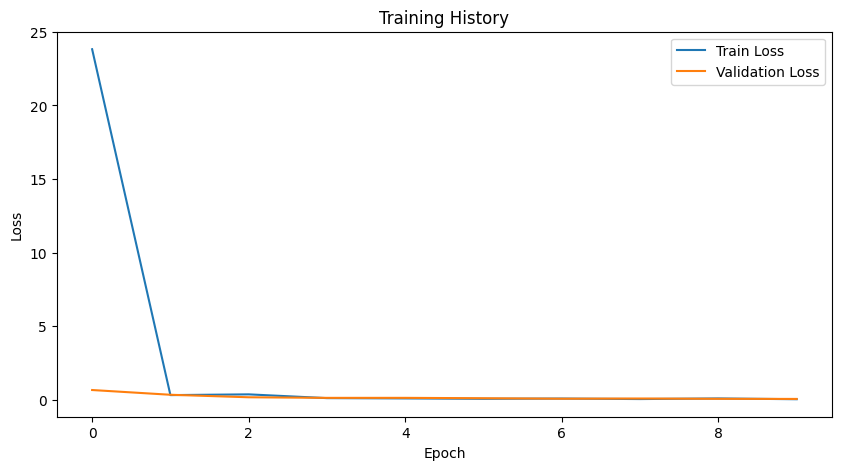

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.savefig('training_history.png')
plt.show()